In [1]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import least_squares
from scipy import interpolate
from scipy.optimize import curve_fit

In [2]:
f = h5py.File('C:\\Users\josep\Downloads\data_psi_zero.hdf5', 'r')

In [3]:
list(f.keys())

['DSV_00', 'U', 'Uk', 'eta', 'k', 't', 'x', 'y', 'z']

In [4]:
x = f.get('x')
y = f.get('y')
z = f.get('z')
t = f.get('t')
k = f.get('k')
U = f.get('U')
Uk = f.get('Uk')

In [5]:
x = np.array(x)
y = np.array(y)
z = np.array(z)
t = np.array(t)
k = np.array(k)
U = np.array(U)
Uk = np.array(Uk)

In [6]:
surf3d = surface_core.surface_from_file("C:\\Users\josep\Downloads\data_psi_zero.hdf5")

In [57]:
spec3d = surf3d.define_SpectralAnalysis()

In [58]:
FFT_spec = spec3d.spectrum()
# 3d array 

In [15]:
FFT_spec.shape

(1200, 66, 66)

In [335]:
def plot_disp_shell(axes, h, z, U, psi, label='', plot_type='surf', linestyles='line', put_clabel=True):
    g = 9.81
    alpha = 0.5 # value that defines opacity in plot
    dk = 0.005
    k = np.arange(0.01, 0.35, dk)
    dtheta=0.05
    theta=np.arange(0, 2*np.pi+dtheta, dtheta)
    kk, th = np.meshgrid(k, theta, indexing='ij')
    U_eff = 2*kk*np.sum(U*np.exp(np.outer(2*kk,z)), axis=1).reshape(kk.shape)*np.abs(z[1]-z[0])
    ww = kk*U_eff*np.cos(theta-psi) + np.sqrt(kk*g*np.tanh(kk*h))
    kx = kk*np.cos(th)
    ky = kk*np.sin(th)
    if plot_type=='surf':
        axes.plot_surface(kx, ky, ww, alpha=alpha, label=label)
        axes.set_xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$')
        axes.set_ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        axes.set_zlabel(r'$\omega~[\mathrm{rad~s}^{-1}]$')
    elif plot_type=='contour':
        levels = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
        c = plt.contour(kx, ky, ww, levels=levels, linestyles=linestyles)#, label=label)
        if put_clabel:
            plt.clabel(c)
        plt.xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$') 
        plt.ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        plt.axis('equal')
        
    return kx, ky, ww

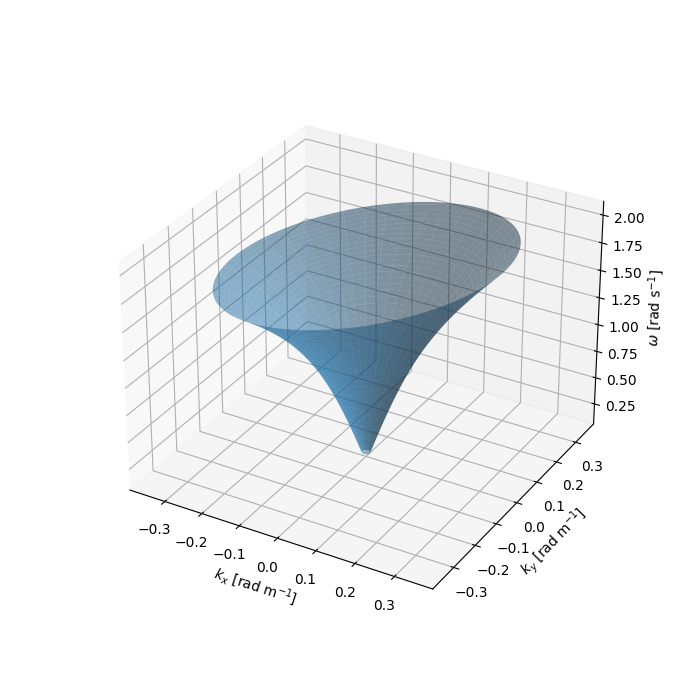

In [336]:
fig = plt.figure(figsize=(7,7))
axes = fig.add_subplot(111, projection='3d')
kx, ky, ww = plot_disp_shell(axes, h=10, z=z, U=U, psi=0)

In [333]:
%matplotlib widget
# makes plots interactive

In [331]:
ky

array([[ 0.        ,  0.00049979,  0.00099833, ..., -0.00083089,
        -0.00033179,  0.00016814],
       [ 0.        ,  0.00074969,  0.0014975 , ..., -0.00124634,
        -0.00049769,  0.00025221],
       [ 0.        ,  0.00099958,  0.00199667, ..., -0.00166179,
        -0.00066358,  0.00033628],
       ...,
       [ 0.        ,  0.01674302,  0.03344419, ..., -0.02783495,
        -0.01111504,  0.00563266],
       [ 0.        ,  0.01699292,  0.03394336, ..., -0.0282504 ,
        -0.01128093,  0.00571673],
       [ 0.        ,  0.01724281,  0.03444253, ..., -0.02866584,
        -0.01144683,  0.0058008 ]])

In [326]:
ky[:,0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [327]:
kx[:,0]

array([0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045, 0.05 ,
       0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 , 0.095,
       0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135, 0.14 ,
       0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 , 0.185,
       0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 , 0.225, 0.23 ,
       0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265, 0.27 , 0.275,
       0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 , 0.315, 0.32 ,
       0.325, 0.33 , 0.335, 0.34 , 0.345])

In [328]:
ww[:,0]

array([0.09945258, 0.14925219, 0.19890704, 0.24828436, 0.29726204,
       0.34572921, 0.3935867 , 0.44074734, 0.48713606, 0.5326898 ,
       0.57735722, 0.62109827, 0.66388353, 0.70569348, 0.74651766,
       0.78635382, 0.8252069 , 0.86308821, 0.90001443, 0.93600679,
       0.97109023, 1.00529266, 1.03864424, 1.07117679, 1.10292323,
       1.13391711, 1.16419221, 1.19378216, 1.2227202 , 1.2510389 ,
       1.27877001, 1.30594427, 1.33259134, 1.35873971, 1.38441663,
       1.40964808, 1.43445879, 1.45887221, 1.48291052, 1.50659472,
       1.52994456, 1.5529787 , 1.57571463, 1.59816883, 1.62035674,
       1.64229285, 1.66399073, 1.6854631 , 1.70672185, 1.72777813,
       1.74864236, 1.76932427, 1.78983298, 1.81017702, 1.83036435,
       1.85040243, 1.87029824, 1.8900583 , 1.90968872, 1.92919523,
       1.94858319, 1.96785761, 1.98702321, 2.00608442, 2.02504537,
       2.04390997, 2.06268188, 2.08136456])

In [337]:
plt.plot(kx[:,0], ww[:,0])

plt.scatter(np.array([0.04301255187, 0.3066398521707972, 0.2063441768530679, 0.10080238071381617]), 
            np.array([0.6754424205218053, 1.7121679962064364, 1.4084807063594234, 1.0000736613927508]), 
            color= 'red', s=40, label="New Trips")

In [311]:
kx.shape

(68, 127)

In [316]:
ww.shape

(68, 127)

In [24]:
FFT_spec[0]

array([[8.08448245e-11, 8.04448126e-11, 7.92351793e-11, ...,
        7.69202100e-11, 7.92351793e-11, 8.04448126e-11],
       [8.26274044e-11, 8.40336723e-11, 8.45450464e-11, ...,
        7.23470679e-11, 7.69223490e-11, 8.02539750e-11],
       [8.80727465e-11, 9.15182353e-11, 9.42511780e-11, ...,
        7.09461490e-11, 7.84368641e-11, 8.38550234e-11],
       ...,
       [9.84704564e-11, 9.17370404e-11, 8.38289587e-11, ...,
        1.15278037e-10, 1.09487819e-10, 1.04127689e-10],
       [8.80727465e-11, 8.38550234e-11, 7.84368641e-11, ...,
        9.70534669e-11, 9.42511780e-11, 9.15182353e-11],
       [8.26274044e-11, 8.02539750e-11, 7.69223490e-11, ...,
        8.47510660e-11, 8.45450464e-11, 8.40336723e-11]])

In [25]:
kx = spec3d.kx
ky = spec3d.ky 
w = spec3d.w

In [59]:
len(w)

1200

In [107]:
def plot_kx_w_spec(kx, w, spec, radial_filter=False, extent=None, ax=None, colorbar=False, spec_min=None, spec_max=None, cmap='viridis'):    
    if not spec_min is None:
        data = np.where(spec<spec_min, spec_min, spec)
    if not spec_max is None:
        data = np.where(spec>spec_max, spec_max, spec)
    ax = plotting_interface.plot_3d_as_2d(kx, w, spec, radial_filter, extent, ax, aspect='auto', colorbar=colorbar, data_min=spec_min, data_max=spec_max, cmap=cmap)
    ax.set_xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$') 
    ax.set_ylabel(r'$\omega$')
    return ax

In [108]:
def plot_ky_slice(self, at_ky, ax=None, dB=None, vmin=None, save=False):
        '''
        plots the integrated kx-w-spectrum 
        '''
        if at_ky > 0:
            i = np.argmin(np.abs(self.ky[len(x)//2:]-at_ky))
            print(at_ky, self.ky[len(x)//2+i], i) 
            plot_kx_w_spec(self.kx, self.w, FFT_spec[len(x)//2+i,:,:], ax=ax)
        else:
            i = np.argmin(np.abs(self.w[:len(x)//2]-at_ky))
            print(at_ky, self.w[i], i) 
            plot_kx_w_spec(self.kx, self.ky, FFT_spec[i,:,:], ax=ax)

0.5 0.4061857168277712 32


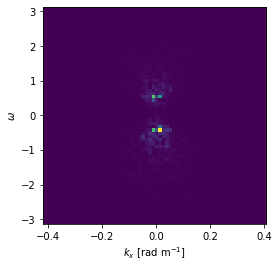

In [213]:
plot_ky_slice(self = spec3d, at_ky = 0.5)

In [281]:
at_ky = 0

In [282]:
i = np.argmin(np.abs(spec3d.ky[len(x)//2:]-at_ky))
i

0

In [283]:
# finding index of first positive value in w => this limits to only positive w values
posit_ind = np.where(spec3d.w > 0)[0]

# Check if any positive value exists
if first_positive_index.size > 0:
    print(posit_ind[0])

601


In [284]:
kx_w = FFT_spec[posit_ind[0]:,:,len(x)//2 + i]
# Limit w values to be only the positive w values

In [285]:
max_index = np.unravel_index(np.argmax(kx_w), kx_w.shape)
max_index

(157, 32)

In [286]:
max_w = spec3d.w[posit_ind[0]+max_index[0]]
max_kx = spec3d.kx[max_index[1]]

In [287]:
max_w

0.8272860654453118

In [288]:
max_kx

-0.012693303650867849

In [289]:
np.sqrt(max_kx**2 + at_ky**2)

0.012693303650867849

# Plot disp relations kx vs w at ky =0

In [295]:
kx

array([-0.41887902, -0.40618572, -0.39349241, -0.38079911, -0.36810581,
       -0.3554125 , -0.3427192 , -0.33002589, -0.31733259, -0.30463929,
       -0.29194598, -0.27925268, -0.26655938, -0.25386607, -0.24117277,
       -0.22847947, -0.21578616, -0.20309286, -0.19039955, -0.17770625,
       -0.16501295, -0.15231964, -0.13962634, -0.12693304, -0.11423973,
       -0.10154643, -0.08885313, -0.07615982, -0.06346652, -0.05077321,
       -0.03807991, -0.02538661, -0.0126933 ,  0.        ,  0.0126933 ,
        0.02538661,  0.03807991,  0.05077321,  0.06346652,  0.07615982,
        0.08885313,  0.10154643,  0.11423973,  0.12693304,  0.13962634,
        0.15231964,  0.16501295,  0.17770625,  0.19039955,  0.20309286,
        0.21578616,  0.22847947,  0.24117277,  0.25386607,  0.26655938,
        0.27925268,  0.29194598,  0.30463929,  0.31733259,  0.33002589,
        0.3427192 ,  0.3554125 ,  0.36810581,  0.38079911,  0.39349241,
        0.40618572])

In [296]:
ky

array([-0.41887902, -0.40618572, -0.39349241, -0.38079911, -0.36810581,
       -0.3554125 , -0.3427192 , -0.33002589, -0.31733259, -0.30463929,
       -0.29194598, -0.27925268, -0.26655938, -0.25386607, -0.24117277,
       -0.22847947, -0.21578616, -0.20309286, -0.19039955, -0.17770625,
       -0.16501295, -0.15231964, -0.13962634, -0.12693304, -0.11423973,
       -0.10154643, -0.08885313, -0.07615982, -0.06346652, -0.05077321,
       -0.03807991, -0.02538661, -0.0126933 ,  0.        ,  0.0126933 ,
        0.02538661,  0.03807991,  0.05077321,  0.06346652,  0.07615982,
        0.08885313,  0.10154643,  0.11423973,  0.12693304,  0.13962634,
        0.15231964,  0.16501295,  0.17770625,  0.19039955,  0.20309286,
        0.21578616,  0.22847947,  0.24117277,  0.25386607,  0.26655938,
        0.27925268,  0.29194598,  0.30463929,  0.31733259,  0.33002589,
        0.3427192 ,  0.3554125 ,  0.36810581,  0.38079911,  0.39349241,
        0.40618572])

In [297]:
w

array([-3.14159265, -3.13635667, -3.13112068, ...,  3.12588469,
        3.13112068,  3.13635667])